# Greystone Python datascience challenge
Author: Gabrielle Agrocostea <br>
Date: December 14th, 2017

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from uszipcode import ZipcodeSearchEngine
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# imports for machine learning
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
# set options
sns.set_style('whitegrid')
pd.set_option('display.max_columns',40)
pd.options.display.max_colwidth = 50
pd.options.display.max_rows = 20
plt.rcParams['figure.figsize'] = (12,6)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Helper function for cross validation plotting found here:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt , train_scores_mean, test_scores_mean

In [3]:
project_dir = '/Users/gabrielle.agrocostea/Documents/dev/ds/greystone/'
data_dir = os.path.join(project_dir, 'data/')

## Part 1) Data Processing and Cleaning

While cleaning up some of the missing and errors in the data, I made the assumption that rows with property value "error" or 0 were mistakes in the data and I dropped these from the data. Also, I assumed that rows with loan amount equal to 0 were errors as these did not make much sense. I also removed rows where there was more than one year built value in the data. I used the ZipcodeSearchEngine library to map zip codes to states (downloaded this using pip).
I created "Age" feature by subtracting 2017 from the first payment date, and I also added a column for days based on maturity date - first payement date. 

In [4]:
# read data
df = pd.read_csv(data_dir + 're_data.csv', encoding='utf-8')

In [5]:
# take a look at data
df.head()

,First Payment Date,Maturity Date,Loan Amount,Zip,Property Value,Year Built,Net Operating Income,Effective Gross Income,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense
0,2017-06-01,2022-05-01,2143864.02,60077.0,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12
1,2017-06-01,2037-05-01,1445991.78,33441.0,1798349.3,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00
2,2017-06-01,2037-05-01,2725017.88,94597.0,1653153.29,1959,230180.51,305261.44,71830.08,11574.56,0.00,39049.76,3869.46,381.04,0.00
3,2017-07-01,2037-06-01,4203448.93,95670.0,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43
4,2017-06-01,2027-05-01,872183.47,90008.0,1306139.1,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00


In [6]:
# clean up column names
df.columns = df.columns.str.replace(" ", "_").str.lower()

In [7]:
# need to convert zip to integer & property_value
# there are some missing dates, zip codes and year built info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 15 columns):
first_payment_date          952 non-null object
maturity_date               952 non-null object
loan_amount                 967 non-null float64
zip                         955 non-null float64
property_value              967 non-null object
year_built                  944 non-null object
net_operating_income        967 non-null float64
effective_gross_income      967 non-null float64
total_operating_expenses    967 non-null float64
maintenance_expense         967 non-null float64
parking_expense             967 non-null float64
taxes_expense               967 non-null float64
insurance_expense           967 non-null float64
utilities_expense           967 non-null float64
payroll_expense             967 non-null float64
dtypes: float64(11), object(4)
memory usage: 113.4+ KB


In [8]:
# we can see that the minimum loan amount = 0 - remove these
df.describe()

,loan_amount,zip,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense
count,9.670000e+02,955.000000,9.670000e+02,9.670000e+02,9.670000e+02,967.000000,967.000000,9.670000e+02,967.000000,967.000000,9.670000e+02
mean,5.095295e+06,44352.730890,5.238723e+05,9.548187e+05,4.305834e+05,70199.903847,3182.816339,1.003292e+05,25099.947363,48176.264261,9.113787e+04
std,8.993072e+06,33382.890668,7.293450e+05,1.299550e+06,5.940979e+05,97626.927154,14922.946908,1.654619e+05,32619.240346,84176.832539,1.609990e+05
min,0.000000e+00,1089.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.174269e+06,11221.000000,1.470790e+05,2.147003e+05,5.693428e+04,7159.150000,0.000000,1.543984e+04,4933.565000,5469.170000,2.911955e+03
50%,2.374118e+06,34207.000000,2.481399e+05,4.161336e+05,1.568649e+05,27142.620000,0.000000,3.994521e+04,11596.030000,16652.450000,1.270349e+04
75%,4.680216e+06,77081.500000,5.803711e+05,1.176544e+06,6.112534e+05,106404.740000,0.000000,1.019358e+05,34239.185000,48902.285000,1.381299e+05
max,1.262039e+08,99336.000000,9.389323e+06,1.461021e+07,4.881435e+06,910269.310000,209666.530000,1.681960e+06,260119.500000,775139.800000,2.577489e+06


In [9]:
# looks like property value needs to be converted
df.property_value.value_counts().head()

0.0            16
Error          14
2155490.04      1
10325313.05     1
2315991.09      1
Name: property_value, dtype: int64

In [10]:
# remove rows where loan amount =0
df = df[df.loan_amount >0.0]

In [11]:
# convert property values
# but first remove error rows
df = df[(df.property_value != 'Error')]
# convert to float
df.property_value = df.property_value.astype(np.float)
# remove rows where property is valued at 0 - these are most likey errors
df = df[(df.property_value > 0.0)]

In [12]:
df.describe()

,loan_amount,zip,property_value,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense
count,8.140000e+02,809.000000,8.140000e+02,8.140000e+02,8.140000e+02,8.140000e+02,814.000000,814.000000,8.140000e+02,814.000000,814.000000,8.140000e+02
mean,5.973412e+06,45532.394314,9.681881e+06,5.334839e+05,9.865489e+05,4.525297e+05,73653.838292,3338.620467,1.064124e+05,26298.646376,50758.228993,9.599278e+04
std,9.470862e+06,33262.857179,1.389185e+07,7.315908e+05,1.306550e+06,5.977152e+05,97690.373961,15573.063853,1.724365e+05,33380.850427,84539.966415,1.630415e+05
min,3.067101e+05,1089.000000,9.166744e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,1.622694e+06,11222.000000,2.708885e+06,1.480235e+05,2.161142e+05,6.540288e+04,8588.237500,0.000000,1.732718e+04,5429.407500,6246.907500,2.994003e+03
50%,2.783789e+06,35950.000000,4.763185e+06,2.552772e+05,4.320629e+05,1.793217e+05,30260.945000,0.000000,4.195557e+04,12401.415000,18963.800000,1.581044e+04
75%,5.140128e+06,77502.000000,1.077977e+07,6.058921e+05,1.226866e+06,6.519866e+05,111280.810000,0.000000,1.078232e+05,35182.430000,54644.857500,1.517414e+05
max,1.262039e+08,99336.000000,1.605930e+08,9.389323e+06,1.461021e+07,4.881435e+06,910269.310000,209666.530000,1.681960e+06,260119.500000,775139.800000,2.577489e+06


In [13]:
# take a look at missing zip codes
df[df.zip.isnull()]

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense
336,2017-06-01,2024-01-01,2894546.17,NaN,1.021987e+07,1979,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
584,2014-02-01,2024-01-01,2946165.14,NaN,5.845349e+06,1974,374350.62,861595.78,486441.64,90974.29,0.00,109987.44,36410.83,30699.97,92815.79
607,2015-06-01,2025-05-01,9865604.21,NaN,1.474449e+07,1983,949562.87,2084457.18,1153157.62,146459.20,0.00,347736.33,52926.81,155720.92,257704.06
809,2016-10-01,2024-07-01,840081.56,NaN,5.667916e+06,1974,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
869,2017-01-01,2031-12-01,75163573.08,NaN,1.067565e+08,2015,573083.22,728001.43,167603.23,8193.90,55521.64,9604.94,14806.87,23029.38,85858.29


In [14]:
# fill missing zip codes as 0
df.zip.fillna(0,inplace=True)
# convert zip code to integer
df.zip = df.zip.map(lambda x: np.int(x))

In [15]:
# initialize zipcodesearch - use this to map zip to state
search = ZipcodeSearchEngine()
# map zip code to state
states = df.zip.map(lambda x: search.by_zipcode(x)['State'])
# add state information
df['state'] = states

In [16]:
# take a look at states with the most loans
df.state.value_counts().head()

NY    199
CA    108
TX     89
IL     58
NJ     35
Name: state, dtype: int64

In [17]:
# looks like this should be in NY - I googled this
df.loc[(df.zip == 11249), 'state'] = 'NY'

## Part 2) Data Exploration

### a) Average Loan Amount by Stat

To answer this question I grouped the data by state and found the average for each state.<br>
I found that the state with the highest average loan amount is Utah. This doesnt sound quite right, but if we look at the data, there is only 1 loan for Utah (after data cleaning...). In looking at only states with more than 10 loans, then the state with the highest average loan amount is PA.

In [18]:
print "The state with the highest average loan amount is:"
df.groupby('state').loan_amount.mean().nlargest(1)

The state with the highest average loan amount is:


state
UT    36204240.98
Name: loan_amount, dtype: float64

The state with the highest average loan amount is: UT


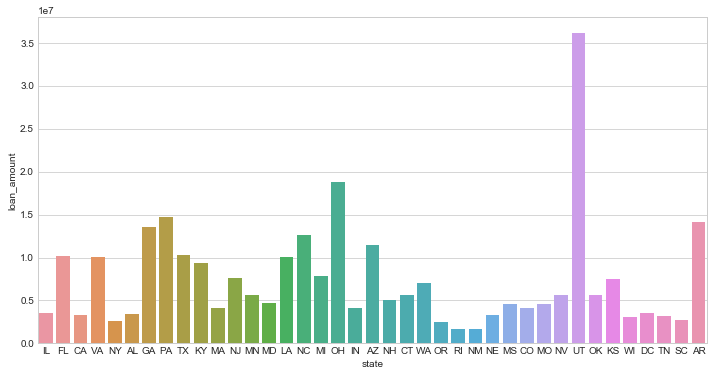

In [19]:
_ = sns.barplot(data=df, x='state', y='loan_amount', estimator=np.mean, ci=None)
print "The state with the highest average loan amount is:", df.groupby('state').loan_amount.mean().nlargest(1).reset_index().state.iloc[0]

In [20]:
# we can see there is only one loan for UT
df[df.state == 'UT']

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense,state
347,2016-12-01,2028-11-01,36204240.98,84119,44613449.29,1985,2590553.95,3995950.67,1363219.35,253990.58,59569.24,244807.33,56193.12,89149.85,433894.85,UT


The state with highest average loan amount is state
PA    1.468275e+07
Name: loan_amount, dtype: float64


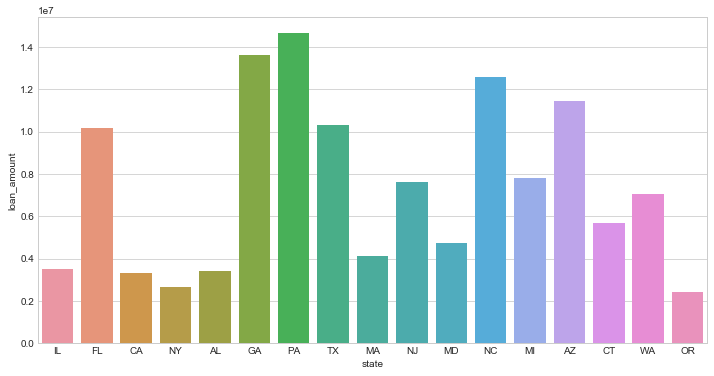

In [21]:
# if we look at states with more than 10 loans 
temp = pd.DataFrame(df.state.value_counts()>10).reset_index()
l = temp[temp.state==True]['index']
print "The state with highest average loan amount is", df[df.state.isin(l)].groupby('state').loan_amount.mean().nlargest(1)
_ = sns.barplot(data= df[df.state.isin(l)], x='state', y='loan_amount', estimator=np.mean, ci=None)

### b) Taxes as a Percentage of property value by State

After filtering rows where property tax and tax expenses arent greater than 0, I calculated tax as a percentage of property value for each row, then grouped by state and found the average. <br> NJ has the highest taxes as a percentage of property value at 2.16% followed by CT at 2.14%. These are very close.

In [22]:
# make sure that value & taxes are greater than 0
temp = df[(df.property_value>0)&(df.taxes_expense>0)]

In [23]:
temp['perc_tax'] = temp.taxes_expense/temp.property_value*100.0

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
temp.groupby('state')['perc_tax'].mean().sort_values(ascending =False).head(5)

state
NJ    2.167168
CT    2.141193
TX    1.793479
RI    1.765187
WI    1.623121
Name: perc_tax, dtype: float64

### c) Strongest Predictor of Maintenance Expense (as a percentage of property value)

Looking at the correlation of maintenance expense as a percentage of property value to the other variables shows that maintenance and insurance expenses are slightly correlated. Maintenance fees usually cover monthly expenses such as water, sewer, trash removal, exterior maintenance, and insurance protects the property and possessions against damage or theft and so on, so these are quite related. When plotting a heatmap of the correlation of maintenance as a percentage, I found it interesting that there is a slightly linear negative relationship between parking expenses &  loan amount and the maintenance expense ratio.<br>

I looked at the correlation of maintenance expenses to the other variables and just like the maintenance ratio, it is positively correlated to insurance expenses, but there is no negative inclination as there is with maintenance as a percentage of property value. Total operating expenses have the highest correlation to maintenance expense which could be explained by the fact that as buildings age they have lower values and so the maintenance costs isnt as high as in a new building (diminishing marginal costs to maintenance). 
In addition, in looking at pairplots of maintenance expenses, we can see that it is linearly related to many variables such as loan amount, effective_gross_income and net_operating_income.

In [25]:
# make a copy of data
temp = df.copy()
temp[(temp.maintenance_expense>0) & (df.property_value>0)]
temp['maintenance_perc'] = temp.maintenance_expense/temp.property_value *100

In [26]:
# correlation of maintenance as a percentage of property value
temp.corr()['maintenance_perc'].sort_values()

parking_expense            -0.044900
property_value             -0.021869
loan_amount                -0.004672
net_operating_income        0.062673
taxes_expense               0.072492
effective_gross_income      0.155580
zip                         0.200744
payroll_expense             0.238786
utilities_expense           0.242587
total_operating_expenses    0.265953
insurance_expense           0.281283
maintenance_expense         0.438455
maintenance_perc            1.000000
Name: maintenance_perc, dtype: float64

In [27]:
# correlation of maintenance as a percentage of property value
temp.corr()['maintenance_expense'].sort_values()

zip                         0.120884
parking_expense             0.185172
maintenance_perc            0.438455
utilities_expense           0.612036
loan_amount                 0.714314
property_value              0.714586
taxes_expense               0.720887
payroll_expense             0.768922
insurance_expense           0.791934
net_operating_income        0.818137
effective_gross_income      0.876467
total_operating_expenses    0.906589
maintenance_expense         1.000000
Name: maintenance_expense, dtype: float64

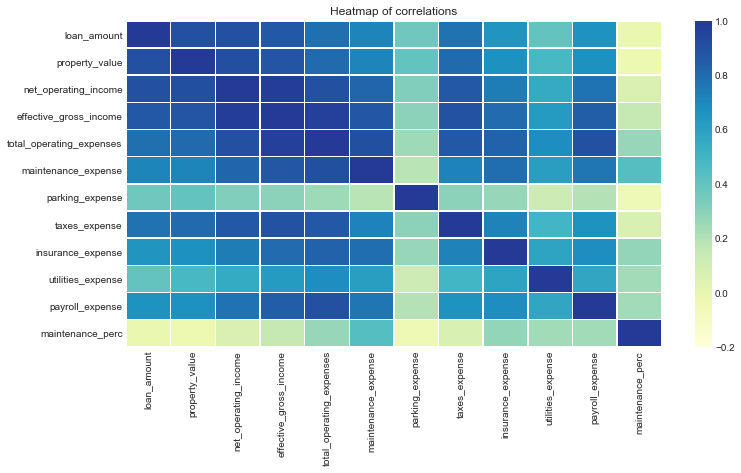

In [28]:
# heatmap of correlations
_ = sns.heatmap(temp.drop(['zip'],axis=1).corr(), linewidths=.5, cmap="YlGnBu", vmin=-.2, vmax=1.0, center=.5)
_ = plt.title("Heatmap of correlations")

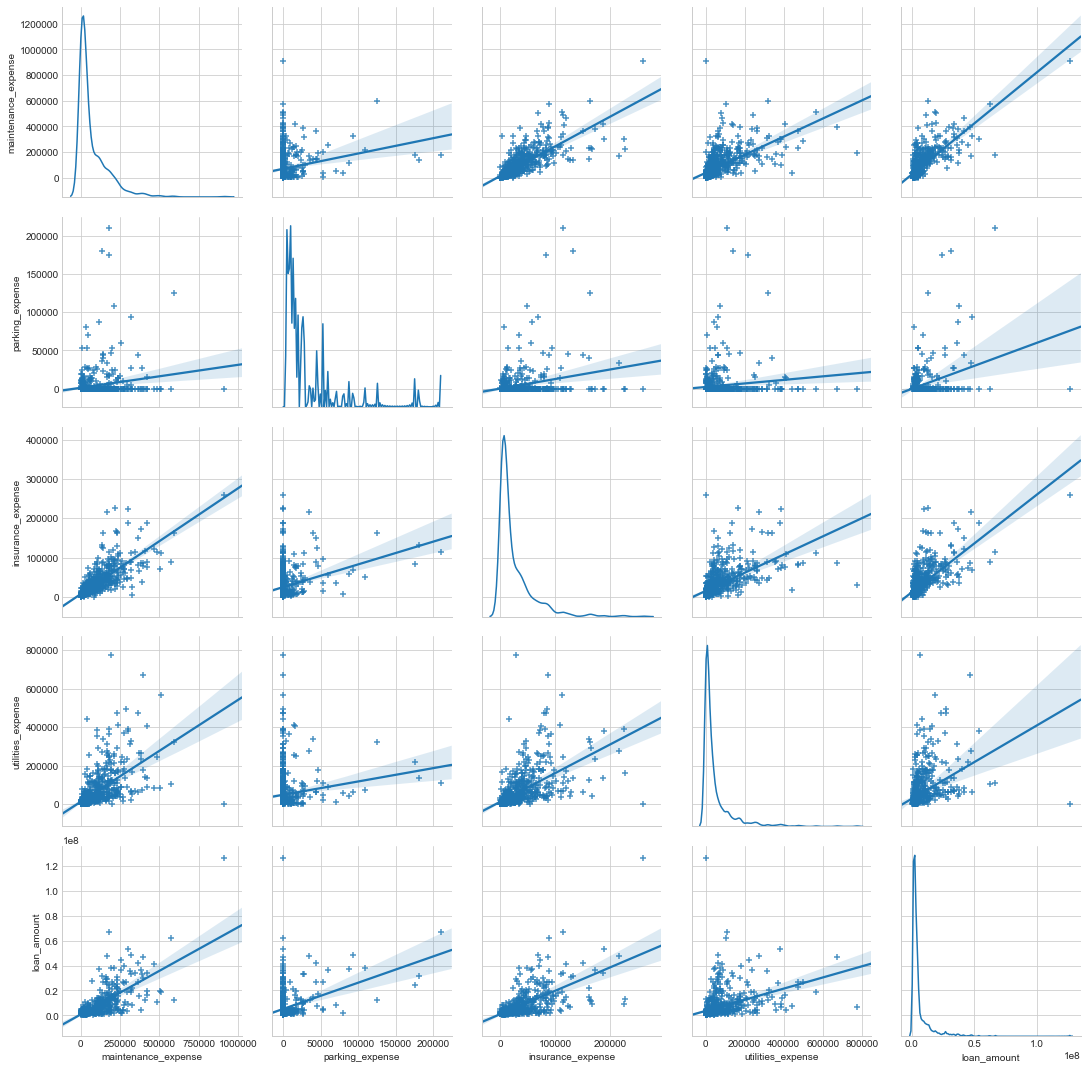

In [29]:
# pairplot of maintenance expense and other variables
vars_plot =  ['maintenance_expense', 'parking_expense','insurance_expense','utilities_expense','loan_amount']
_ = sns.pairplot(data=temp.dropna(), vars = vars_plot, 
             palette="husl", kind = 'reg', size =3,
            diag_kind="kde", markers="+")

### d) Median, Range and Variance in Loan to Value of loans

In looking at the loan to property value, we can see that the median is around 0.68, the variance is quite small at 0.03 and the range is 0.82. The box plot shows that most of the loan to property value percentages are between 60%-75%, and the linear plot shows that there is a significant relationship between the loan amount and property value, and that this is a pretty deterministic calculation. The range is quite large, which could be caused by data issues.

In [30]:
# make sure there are no loans with 0 property value & 0 loan amt
df[(df.loan_amount ==0) & (df.property_value==0)]

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense,state


In [31]:
# calculate loan to value percentage
df['loan_to_val'] = (df.loan_amount/df.property_value)

In [32]:
# looks like there is a loan larger than property value
df.loan_to_val.describe()

count    814.000000
mean       0.640294
std        0.173400
min        0.027369
25%        0.607356
50%        0.683980
75%        0.757899
max        1.648376
Name: loan_to_val, dtype: float64

In [33]:
# remove this outlier
df[df.loan_to_val >=1.0]
df = df[df.loan_to_val<1.0]

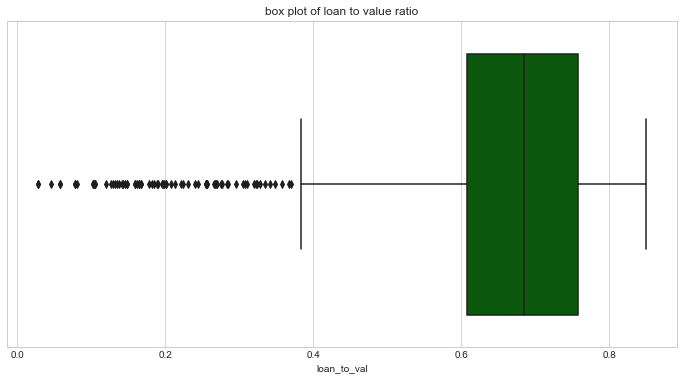

In [34]:
temp = df.copy()
sns.boxplot(data=temp, x='loan_to_val', color='darkgreen')
plt.title('box plot of loan to value ratio')

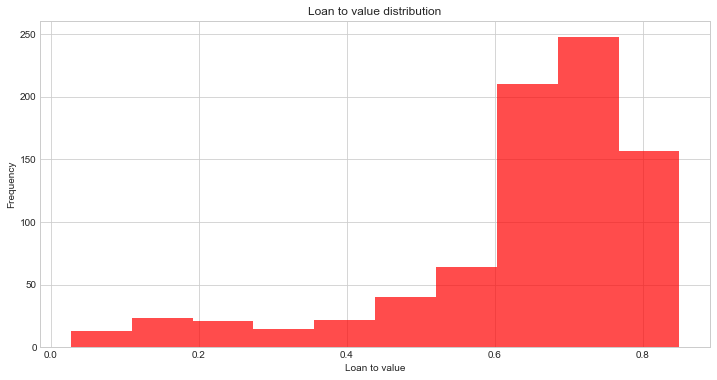

In [35]:
_ = plt.hist(temp.loan_to_val, color='red', alpha=.7)
_ = plt.title('Loan to value distribution')
_ = plt.xlabel("Loan to value")
_ = plt.ylabel("Frequency")

In [36]:
# print loan to value info
print "Loan to Value summary statistics:\n"
print "Median: %.2f" % temp.loan_to_val.median()
print "Range: %.2f" % (temp.loan_to_val.max() - temp.loan_to_val.min())
print "Variance: %.2f" % temp.loan_to_val.var(), "\n"

Loan to Value summary statistics:

Median: 0.68
Range: 0.82
Variance: 0.03 



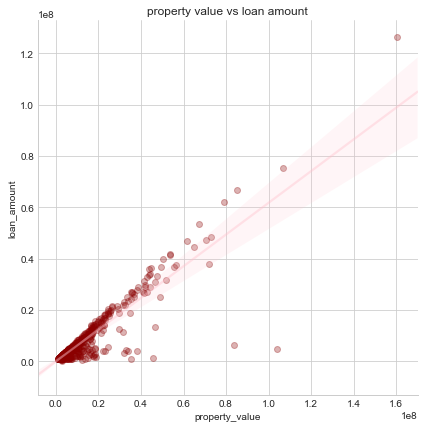

In [37]:
_ = sns.lmplot(data = df, x = 'property_value', y = 'loan_amount', 
           line_kws={'color':'pink', 'alpha':.4},
           scatter_kws={"color":"darkred","alpha":0.3}, size = 6)
_ =  plt.title('property value vs loan amount')

### e) Larger valuations and economies of scale with regard to expenses

To keep this from being too lengthy, I looked at total expenses (the sum over all expenses) as well as insurance expense vs. property value.
In looking at the total expenses vs. property value,  there is a clear linear relationship between these two (the correlation is .81), so as the value of a property increases so do the total expenses (which makes sense). However when looking at the total expense as a percentage of property value, there is no real correlation with the property value (the correlation is 0.04), so there is no economy of scale.
In the case of insurance expenses these are also correlated to property value (.67) but slightly negatively correlated to the insurance expense ratio. This tells us that the ratio expenses to property value decreases as property value increases which could be an economy of scale, but the correlation here is very small.


In [38]:
temp = df.copy()
expense_cols = temp.columns[temp.columns.str.contains('expense')]
expense_cols = list(expense_cols)
temp['total_expenses'] = temp[expense_cols].sum(axis=1)
# remove rows where total expenses = 0
temp = temp[(temp.total_expenses >0) & (temp.property_value>0)]
# remove rows where insurance expenses = 0
temp = temp[(temp.insurance_expense >0) & (temp.property_value>0)]
# total expense as a percentage of property value
temp['expense_perc'] = temp.total_expenses/temp.property_value
# total insurance as a percentage of property value
temp['ins_perc'] = temp.insurance_expense/temp.property_value
temp.head()

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense,state,loan_to_val,total_expenses,expense_perc,ins_perc
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12,IL,0.713812,223140.33,0.074296,0.003033
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.30,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00,FL,0.804066,135121.64,0.075136,0.007230
3,2017-07-01,2037-06-01,4203448.93,95670,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43,CA,0.556448,693457.93,0.091799,0.001515
4,2017-06-01,2027-05-01,872183.47,90008,1306139.10,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00,CA,0.667757,62462.82,0.047822,0.002304
7,2017-05-01,2027-04-01,16920496.31,23669,23143456.92,1943,1397548.03,2448485.05,997905.35,219231.52,0.00,272436.40,34248.91,42082.60,170742.00,VA,0.731114,1736646.78,0.075038,0.001480


In [39]:
print temp[(temp.insurance_expense ==0) & (temp.property_value>0)].shape
print temp[(temp.total_expenses ==0) & (temp.property_value>0)].shape

(0, 20)
(0, 20)


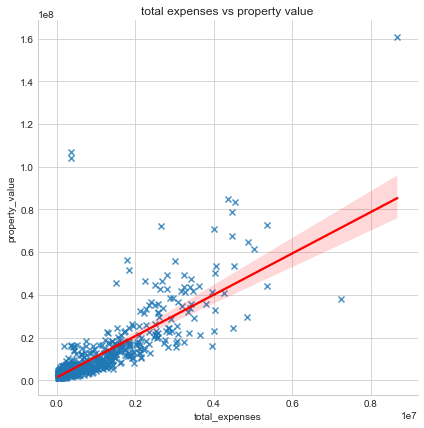

In [40]:
# plot of all expenses vs property value
_ = sns.lmplot(data=temp, y = 'property_value', x='total_expenses', 
           line_kws={'color':'red'}, markers='x', size = 6, truncate=True, robust=True)
_ = plt.title('total expenses vs property value')

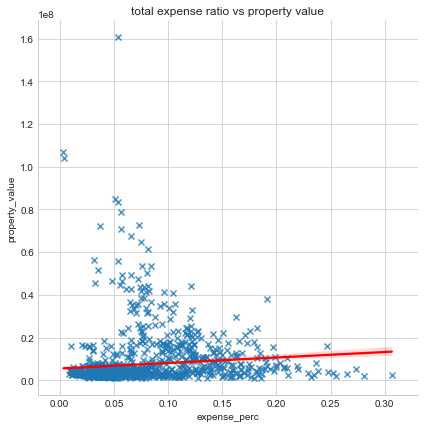

In [41]:
# plot of total expense ratio vs property value
_ = sns.lmplot(data=temp, y = 'property_value', x='expense_perc', 
           line_kws={'color':'red'}, markers='x', size = 6, truncate=True, robust=True)
_ = plt.title('total expense ratio vs property value')

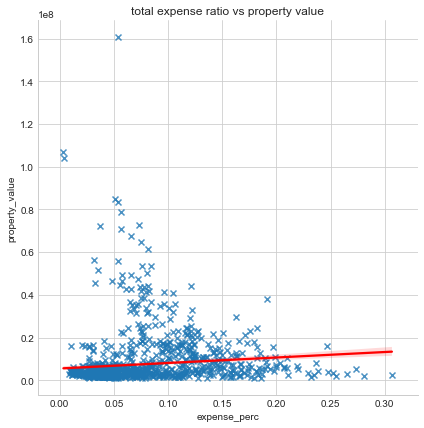

In [42]:
# plot of total expense ratio vs property value
_ = sns.lmplot(data=temp, y = 'property_value', x='expense_perc', 
           line_kws={'color':'red'}, markers='x', size = 6, truncate=True, robust=True, )
_ = plt.title('total expense ratio vs property value')

correlation between total expenses and property value 0.81 with pvalue 1.4804e-185
correlation between total expense ratio and property value 0.04 with pvalue 2.6124e-01


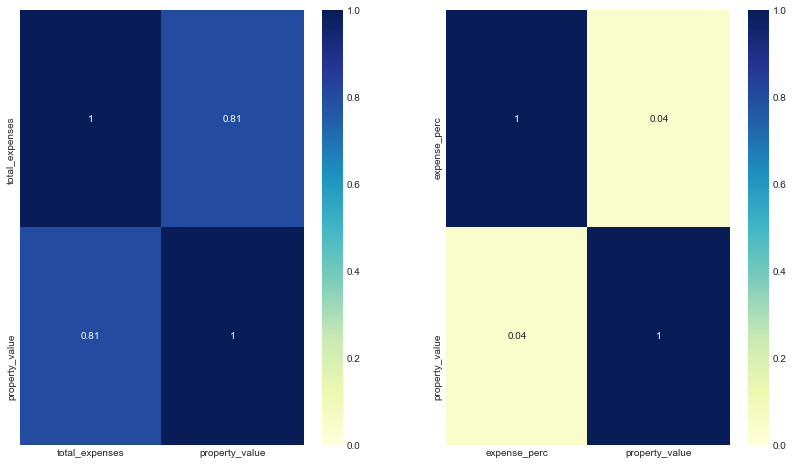

In [44]:
fig, axes = plt.subplots(figsize=(14,8), ncols=2)
_ = sns.heatmap(temp[['total_expenses','property_value']].corr(), 
            cmap="YlGnBu",  vmin=0.0, vmax=1.0, annot = True, ax=axes[0])
_ = sns.heatmap(temp[['expense_perc','property_value']].corr(), 
            cmap="YlGnBu",  vmin=0.0, vmax=1.0, annot = True, ax=axes[1])
print "correlation between total expenses and property value %.2f with pvalue %.4e" % stats.pearsonr(temp.total_expenses, temp.property_value)
print "correlation between total expense ratio and property value %.2f with pvalue %.4e" % stats.pearsonr(temp.expense_perc, temp.property_value)

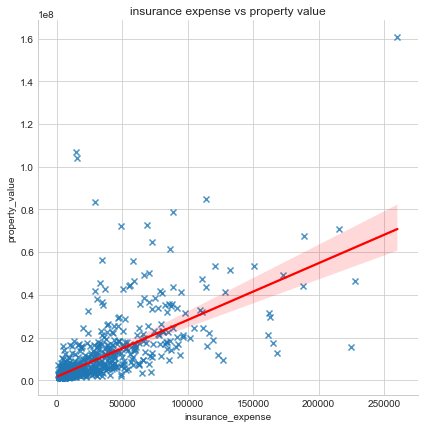

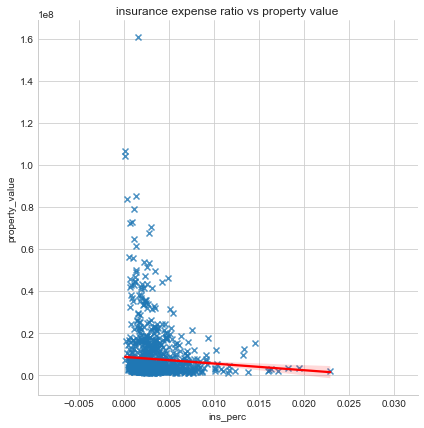

In [45]:
# plot of insurance expense ratio vs property value
_ = sns.lmplot(data=temp, y = 'property_value', x='insurance_expense',
           line_kws={'color':'red'}, markers='x', size = 6, truncate=True, robust=True)
_ = plt.title('insurance expense vs property value')
# plot of insurance expense ratio vs property value
_ = sns.lmplot(data=temp, y = 'property_value', x='ins_perc',
           line_kws={'color':'red'}, markers='x', size = 6, truncate=True, robust=True)
_ = plt.title('insurance expense ratio vs property value')

correlation between insurance expenses and property value 0.67 with pvalue 2.3878e-104
correlation between insurance expense ratio and property value -0.15 with pvalue 2.2835e-05


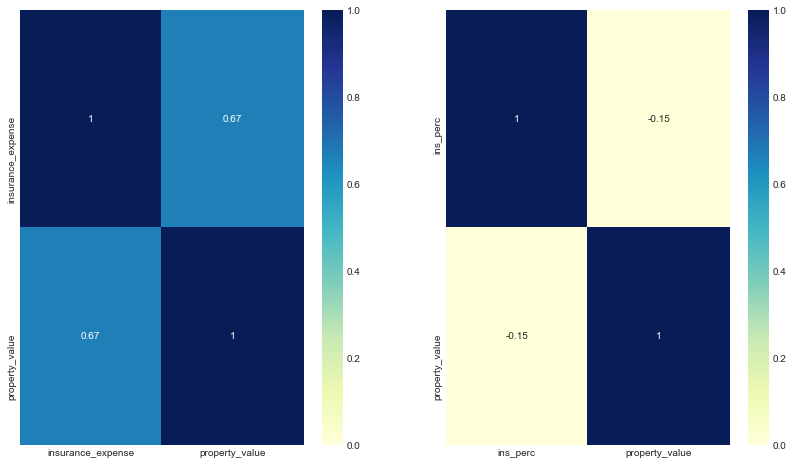

In [46]:
fig, axes = plt.subplots(figsize=(14,8), ncols=2)
_ = sns.heatmap(temp[['insurance_expense','property_value']].corr(), 
            cmap="YlGnBu",  vmin=0.0, vmax=1.0, annot = True, ax=axes[0])
_ = sns.heatmap(temp[['ins_perc','property_value']].corr(), 
            cmap="YlGnBu",  vmin=0.0, vmax=1.0, annot = True, ax=axes[1])
print "correlation between insurance expenses and property value %.2f with pvalue %.4e" % stats.pearsonr(temp.insurance_expense, temp.property_value)
print "correlation between insurance expense ratio and property value %.2f with pvalue %.4e" % stats.pearsonr(temp.ins_perc, temp.property_value)

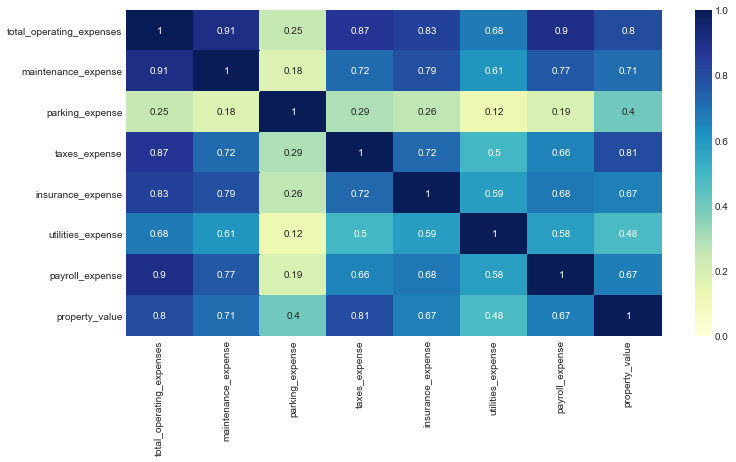

In [47]:
expense_cols.append('property_value')
sns.heatmap(temp[expense_cols].corr(),  cmap="YlGnBu",  vmin=0.0, vmax=1.0, annot=True)

## Part 3) Data Visualization 

### a) Expense ratio by State 

In [48]:
temp = df.copy()
temp['expense_ratio'] = temp.total_operating_expenses/temp.effective_gross_income

In [49]:
# remove 0 values
temp = temp[(temp.total_operating_expenses  >0) & (temp.effective_gross_income>0)]
temp.expense_ratio.describe()

count    804.000000
mean       0.410307
std        0.133708
min        0.081854
25%        0.314892
50%        0.413901
75%        0.509176
max        0.949870
Name: expense_ratio, dtype: float64

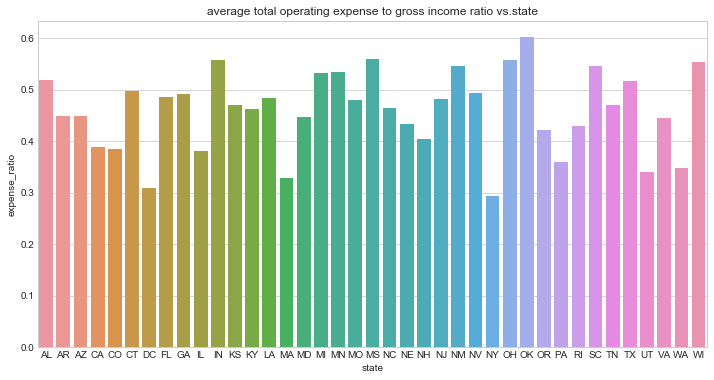

In [50]:
# plot average expense ratio by state
# we see OK has the highest average expense ratio
temp2 = temp.groupby('state').expense_ratio.mean()
temp2 = temp2.reset_index()
_ =  sns.barplot(data = temp2, x = 'state', y = 'expense_ratio')
_ = plt.title('average total operating expense to gross income ratio vs.state')

### b) Relationship between Age of Property and Expenses

In [51]:
# clean up data
df = df[~df.year_built.isnull()]
df = df[df.year_built.str.split(' ').map(lambda x: len(x)==1)]
df = df[df.year_built.str.split(',').map(lambda x: len(x)==1)]
df.year_built = df.year_built.astype(int)
df['age'] = 2017 - df.year_built

In [52]:
df['total_expenses'] = df[expense_cols].sum(axis=1)
df.head()

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense,state,loan_to_val,age,total_expenses
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12,IL,0.713812,52,3226540.57
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.30,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00,FL,0.804066,57,1933470.94
3,2017-07-01,2037-06-01,4203448.93,95670,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43,CA,0.556448,41,8247535.59
4,2017-06-01,2027-05-01,872183.47,90008,1306139.10,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00,CA,0.667757,65,1368601.92
7,2017-05-01,2027-04-01,16920496.31,23669,23143456.92,1943,1397548.03,2448485.05,997905.35,219231.52,0.00,272436.40,34248.91,42082.60,170742.00,VA,0.731114,74,24880103.70


In [53]:
df.age.describe()

count    808.000000
mean      58.389851
std       31.950283
min        1.000000
25%       34.000000
50%       52.000000
75%       86.000000
max      149.000000
Name: age, dtype: float64

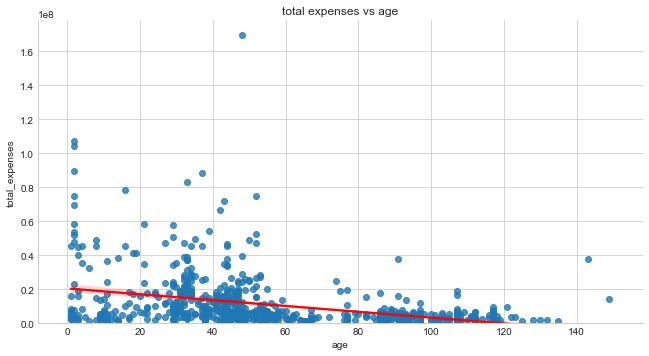

In [54]:
# plot of total expenses vs age
lm_plt = sns.lmplot(data=df, x = 'age', y = 'total_expenses', truncate=True, fit_reg=True, line_kws={'color':'r'})
lm_plt.set(ylim=(0, None))
lm_plt.fig.set_figwidth(10)
_ = plt.title('total expenses vs age')

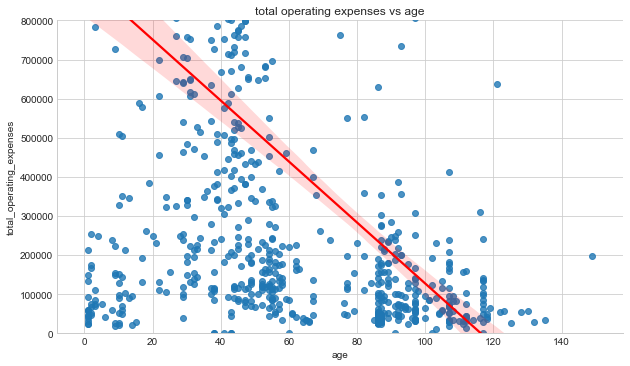

In [55]:
# as age increases total expenses decrease
lm_plt = sns.lmplot(data=df, x = 'age', y = 'total_operating_expenses', truncate=True,fit_reg=True, line_kws={'color':'r'} )
lm_plt.set(ylim=(0, 800000))
lm_plt.fig.set_figwidth(10)
_ = plt.title('total operating expenses vs age')

In [56]:
df[['age','total_expenses']].corr()

,age,total_expenses
age,1.000000,-0.372314
total_expenses,-0.372314,1.000000


### c) Cumulative loan amount by fiscal quarter

In [57]:
# convert date to datetime
df.first_payment_date = pd.to_datetime(df.first_payment_date)
# add fiscal quarter
df['fiscal_qt'] = df.first_payment_date.dt.to_period('Q-DEC')

In [58]:
# create period index of all quarters in data
qts = pd.PeriodIndex(start = df.first_payment_date.min(), end=df.first_payment_date.max(), freq = 'Q-DEC')

In [59]:
# find missing quarters
missing = list(set(df.fiscal_qt.unique()).symmetric_difference(set(qts)))
missing = pd.DataFrame(missing,columns=['fiscal_qt'])

In [60]:
missing

,fiscal_qt
0,2012Q2
1,2014Q4
2,2013Q2
3,2013Q3
4,2012Q3
5,2012Q4
6,2011Q2
7,2011Q3
8,2015Q1
9,2013Q4


/usr/local/lib/python2.7/site-packages/pandas/plotting/_core.py:179: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


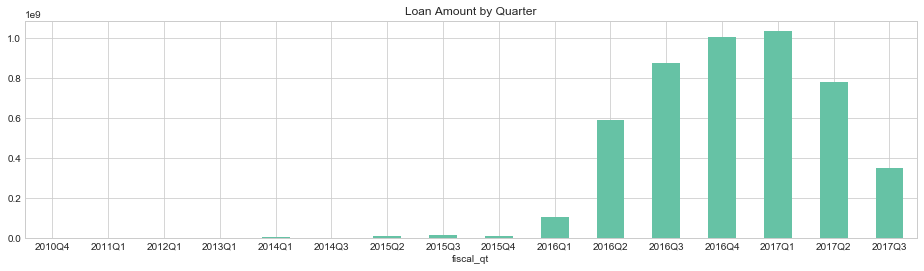

In [61]:
# sum over fiscal quarters
fiscal_qt_loans = df.groupby(['fiscal_qt']).loan_amount.sum()
# loan amounts by quarter plot
fig, ax = plt.subplots(figsize= (16,4))
p = fiscal_qt_loans.plot(ax = ax, kind = 'bar', colors =sns.color_palette("Set2"), stacked = False)
xticks = [item.get_text() for item in p.get_xticklabels()]
# fix tick labels
_ = p.set_xticklabels(labels= xticks, rotation = 0)
_ = p.set_title('Loan Amount by Quarter')

In [62]:
fiscal_cumsum = np.cumsum(fiscal_qt_loans)
fiscal_cumsum = fiscal_cumsum.reset_index()
fiscal_cumsum
# add missing quarters
fiscal_cumsum = fiscal_cumsum.append(missing)
fiscal_cumsum.fillna(0,inplace=True)
fiscal_cumsum.sort_values(by = 'fiscal_qt', ascending= True, inplace=True)
fiscal_cumsum.head()

,fiscal_qt,loan_amount
0,2010Q4,992708.41
1,2011Q1,2987931.26
6,2011Q2,0.00
7,2011Q3,0.00
10,2011Q4,0.00


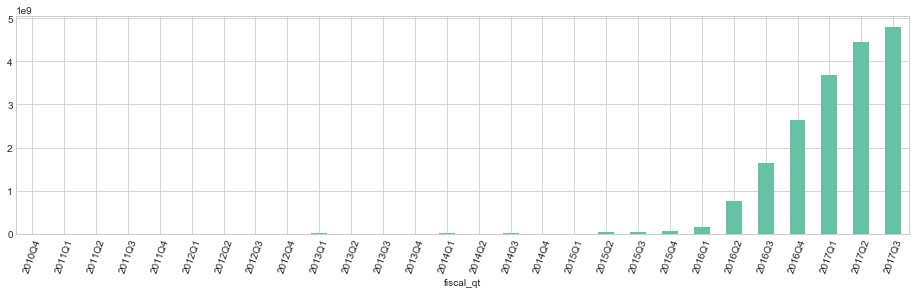

In [63]:
fig, ax = plt.subplots(figsize= (16,4))
p2 = fiscal_cumsum.set_index('fiscal_qt')['loan_amount'].plot(ax=ax, kind = 'bar', 
                                                              colors =sns.color_palette("Set2"), stacked = False)
xticks = [item.get_text() for item in p2.get_xticklabels()]
_ = p2.set_xticklabels(labels= xticks, rotation = 70)
_ = p.set_title('Cummulative Sum of Loan Amount by Quarter')

## Part 4 Predicting loan to value

### Linear Regression Model
I used a simple linear regression model in two ways. First I only used a train/test split of 90%/10% and the model did not perfrom well and the results overestimate the model performance. As a second approach, I used 10-fold cross validation to get a better idea of model performance and can see that the model performs much worse on average.
Using cross-validation we can see that while the model doesnt perform well, more data does improve the validation performance. I think that the model could be improved by adding more data points, and more features. Also, maybe trying another model such as Random Forests could improve the results

In [64]:
model_data = df.copy()
model_data.drop('total_expenses',axis=1,inplace=True)
model_data.dropna(inplace=True)
# add days to maturity based on first payment and maturity date
model_data.maturity_date = pd.to_datetime(model_data.maturity_date)
model_data.first_payment_date = pd.to_datetime(model_data.first_payment_date)
model_data['days_to_maturity'] = model_data.maturity_date - model_data.first_payment_date
model_data.days_to_maturity = model_data.days_to_maturity.map(lambda x: x.days)
# add fiscal quarter
model_data['fiscal_qt'] = pd.PeriodIndex(model_data.first_payment_date, freq = 'Q-DEC')

In [1389]:
# # encode data for state and fiscal quarter using dummies
# dummies_state = pd.get_dummies(model_data.state)
# dummies_fiscal_qt = pd.get_dummies(model_data.fiscal_qt)

In [65]:
# encode categorical columns
le = LabelEncoder()
for c in ['state','fiscal_qt']:
    model_data[c] = le.fit_transform(model_data[c])

In [66]:
model_data.head()

,first_payment_date,maturity_date,loan_amount,zip,property_value,year_built,net_operating_income,effective_gross_income,total_operating_expenses,maintenance_expense,parking_expense,taxes_expense,insurance_expense,utilities_expense,payroll_expense,state,loan_to_val,age,fiscal_qt,days_to_maturity
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12,9,0.713812,52,14,1795
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.30,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00,7,0.804066,57,14,7274
3,2017-07-01,2037-06-01,4203448.93,95670,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43,3,0.556448,41,15,7275
4,2017-06-01,2027-05-01,872183.47,90008,1306139.10,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00,3,0.667757,65,14,3621
7,2017-05-01,2027-04-01,16920496.31,23669,23143456.92,1943,1397548.03,2448485.05,997905.35,219231.52,0.00,272436.40,34248.91,42082.60,170742.00,36,0.731114,74,14,3622


In [67]:
# model_data.year_built = le.fit_transform(model_data.year_built)
model_data.drop(['first_payment_date','maturity_date'], axis=1, inplace=True)

### Linear Regression Model
I first split only into training and test using 10% for test. This model performed poorly but the results overestimate the model performance. When performing 10-fold cross validation we cans see that the model performs a bit worse on average. The R-squared score on test data is when using only one split is 0.23 and this quite low. While using cross-validation this is also the error on the validation set

In [68]:
# shuffle data
X, y = shuffle(model_data.drop(['loan_to_val','loan_amount'],axis=1), model_data.loan_to_val, random_state=0)
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)

In [69]:
# scale data using robust scaler
robustscale = RobustScaler()
# fit to training data
robustscale = robustscale.fit(X_train)
# transform training & test data
X_train_scaled = robustscale.transform(X_train)
X_test_scaled = robustscale.transform(X_test)

In [70]:
# Linear Regression Model
lm = LinearRegression(normalize=True)
# fit linear regression model
lm.fit(X_train_scaled, y_train)
# get R-squared score for training and test
print "R-Squared for train: %.3f" % lm.score(X_train_scaled, y_train)
print "R-Squared for test: %.3f" % lm.score(X_test_scaled, y_test)
# predict test
preds = lm.predict(X_test_scaled)
# Calcualte result metrics
mse = np.mean(np.absolute(y_test - preds))
print 'Mean Absolute Error: %.3f' %mse

R-Squared for train: 0.185
R-Squared for test: 0.234
Mean Absolute Error: 0.097


/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Average R-squared for validation: 0.23
Average R-squared for test: 0.04


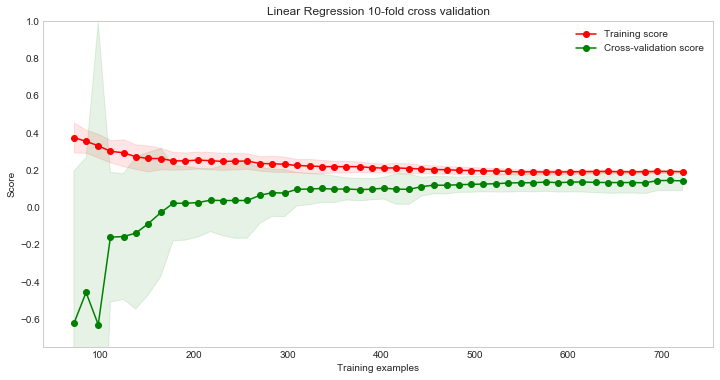

In [71]:
## Cross-validation for better generalization of error ##

# assign predictors and response
# shuffle data
X, y = shuffle(model_data.drop(['loan_to_val','loan_amount'],axis=1), model_data.loan_to_val, random_state=0)
title = "Linear Regression 10-fold cross validation"

# build pipeline for linear model
lm_pipeline = Pipeline(steps=[('robustscale', robustscale), ('lm', LinearRegression())])

# 10-fold Cross validation for smoother mean test and train score curves, 
# each with 10% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=.10, random_state=0)
# split training sets into 50 sets
_, train_scores_mean, test_scores_mean = plot_learning_curve(lm_pipeline, title, X, y, cv=cv,
                                                             n_jobs=-1, ylim=(-0.75,1.0), train_sizes=np.linspace(.1, 1.0, 50))
print "Average R-squared for validation: %.2f" % np.mean(train_scores_mean)
print "Average R-squared for test: %.2f" % np.mean(test_scores_mean)